In [1]:
#import libraries for machine learning
import pandas as pd
from pandas_datareader import data as pdr
from darts import TimeSeries, concatenate
from darts.models import ExponentialSmoothing
import matplotlib.pyplot as plt
from darts.models import RNNModel, NBEATSModel, BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse
from darts.models import Prophet, ARIMA, StatsForecastAutoARIMA, VARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import datetime as dt
import yfinance as yf
yf.pdr_override()
plt.rcParams['figure.figsize'] = [20, 4]

/home/malthe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get Bitcoin data from API
date_start = dt.datetime(2018, 5, 1)
date_end = dt.datetime(2023, 5, 1)

df = pdr.get_data_yahoo('BTC-USD', date_start, date_end)

# Reset the index and create a new 'Date' column
df.reset_index(inplace=True)

# Create time series object
df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
1821,2023-04-26,28300.058594,29995.837891,27324.548828,28422.701172,28422.701172,31854242019
1822,2023-04-27,28428.464844,29871.546875,28402.886719,29473.787109,29473.787109,27153445027
1823,2023-04-28,29481.013672,29572.791016,28929.609375,29340.261719,29340.261719,17544464887
1824,2023-04-29,29336.566406,29452.455078,29088.042969,29248.488281,29248.488281,10662634333
1825,2023-04-30,29245.515625,29952.029297,29114.021484,29268.806641,29268.806641,14652199272


In [3]:
#crate a time series object
ts_close = TimeSeries.from_dataframe(df, 'Date', 'Close')
ts_open = TimeSeries.from_dataframe(df, 'Date', 'Open')
ts_high = TimeSeries.from_dataframe(df, 'Date', 'High')
ts_low = TimeSeries.from_dataframe(df, 'Date', 'Low')
ts_volume = TimeSeries.from_dataframe(df, 'Date', 'Volume')
ts_multi = TimeSeries.from_dataframe(df, 'Date', ['Open', 'Close', 'High', 'Low', 'Volume'])


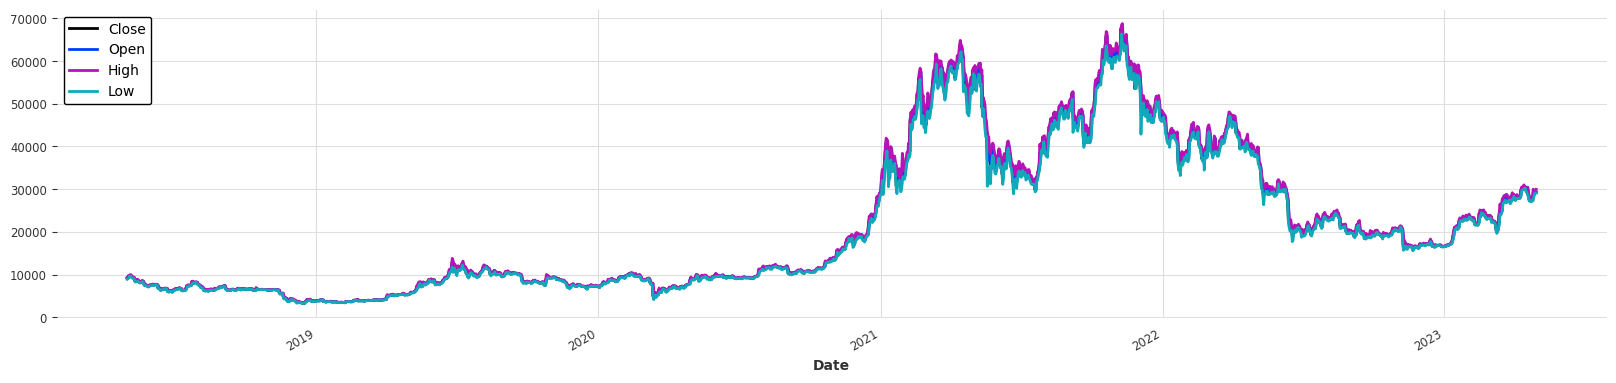

In [4]:
ts_close.plot(label='Close')
ts_open.plot(label='Open')
ts_high.plot(label='High')
ts_low.plot(label='Low')

# Add the legend with a box
legend = plt.legend(loc="upper left", frameon=True)

# Customize the appearance of the legend box
legend.get_frame().set_facecolor("white")  # Set the background color
legend.get_frame().set_edgecolor("black")  # Set the edge color
legend.get_frame().set_alpha(1)  # Set the transparency (0: fully transparent, 1: fully opaque)
plt.show()

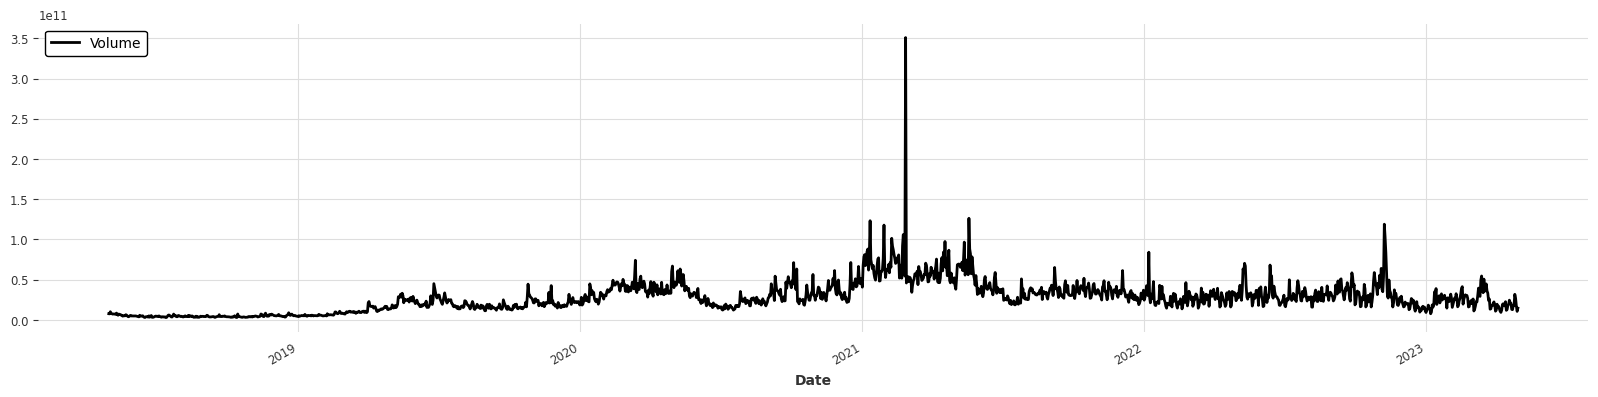

In [5]:
ts_volume.plot(label='Volume')

# Add the legend with a box
legend = plt.legend(loc="upper left", frameon=True)

# Customize the appearance of the legend box
legend.get_frame().set_facecolor("white")  # Set the background color
legend.get_frame().set_edgecolor("black")  # Set the edge color
legend.get_frame().set_alpha(1)  # Set the transparency (0: fully transparent, 1: fully opaque)
plt.show()

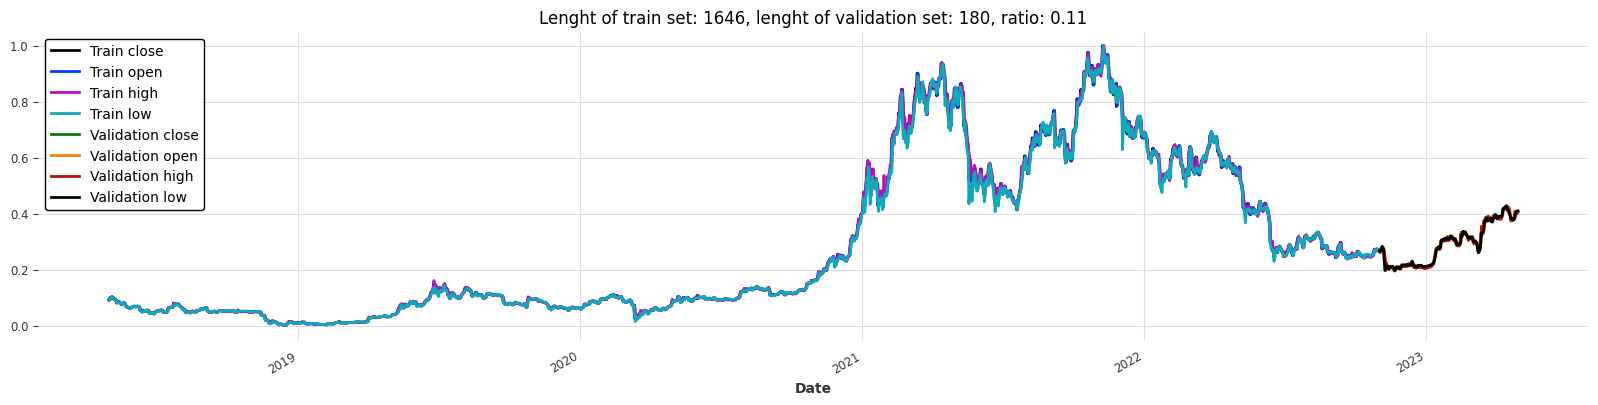

In [6]:
# preproccessing
scalar_close, scalar_open, scalar_high, scalar_low, scalar_volume, scalar_multi = Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
ts_close_scaled = scalar_close.fit_transform(ts_close)
ts_open_scaled = scalar_open.fit_transform(ts_open)
ts_high_scaled = scalar_high.fit_transform(ts_high)
ts_low_scaled = scalar_low.fit_transform(ts_low)
ts_volume_scaled = scalar_volume.fit_transform(ts_volume)
ts_multi_scaled = scalar_multi.fit_transform(ts_multi)


split_date = '2022-11-01'
# make train and validation set
train_close, val_close = ts_close.split_after(pd.Timestamp(split_date))
train_open, val_open = ts_open.split_after(pd.Timestamp(split_date))
train_high, val_high = ts_high.split_after(pd.Timestamp(split_date))
train_low, val_low = ts_low.split_after(pd.Timestamp(split_date))
train_volume, val_volume = ts_volume.split_after(pd.Timestamp(split_date))
train_multi, val_multi = ts_multi.split_after(pd.Timestamp(split_date))

# make scaled train and validation set
train_close_sc, val_close_sc = ts_close_scaled.split_after(pd.Timestamp(split_date))
train_open_sc, val_open_sc = ts_open_scaled.split_after(pd.Timestamp(split_date))
train_high_sc, val_high_sc = ts_high_scaled.split_after(pd.Timestamp(split_date))
train_low_sc, val_low_sc = ts_low_scaled.split_after(pd.Timestamp(split_date))
train_volume_sc, val_volume_sc = ts_volume_scaled.split_after(pd.Timestamp(split_date))
train_multi_sc, val_multi_sc = ts_multi_scaled.split_after(pd.Timestamp(split_date))

# plot scaled train and validation set
train_close_sc.plot(label='Train close')
train_open_sc.plot(label='Train open')
train_high_sc.plot(label='Train high')
train_low_sc.plot(label='Train low')

val_close_sc.plot(label='Validation close')
val_open_sc.plot(label='Validation open')
val_high_sc.plot(label='Validation high')
val_low_sc.plot(label='Validation low')

plt.title(f"Lenght of train set: {len(train_close_sc)}, lenght of validation set: {len(val_close_sc)}, ratio: {len(val_close_sc)/len(train_close_sc):.2f}")

# Add the legend with a box
legend = plt.legend(loc="upper left", frameon=True)

# Customize the appearance of the legend box
legend.get_frame().set_facecolor("white")  # Set the background color
legend.get_frame().set_edgecolor("black")  # Set the edge color
legend.get_frame().set_alpha(1)  # Set the transparency (0: fully transparent, 1: fully opaque)
plt.show()

Text(0, 0.5, 'Volume')

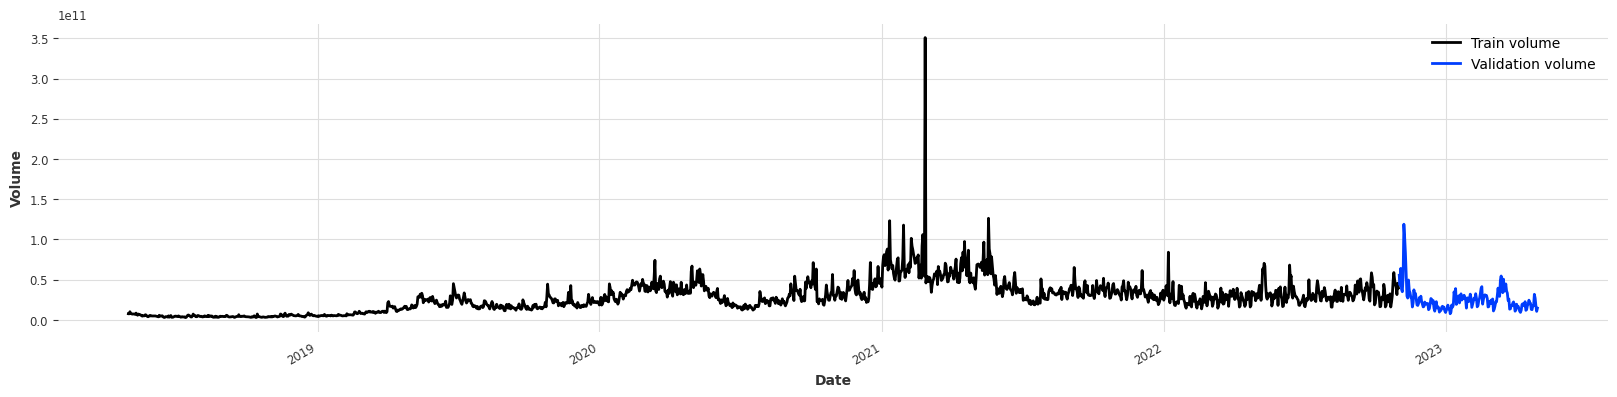

In [7]:
train_volume.plot(label='Train volume')
val_volume.plot(label='Validation volume')
plt.ylabel('Volume')

In [38]:

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=ts_multi.start_time(), freq=ts_multi.freq_str, periods=(len(val_multi_sc)+len(train_multi_sc))),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)

model_lstm = RNNModel(
    model="LSTM",
    hidden_dim=512,
    n_rnn_layers=2,
    dropout=0,
    batch_size=16,
    n_epochs=200,
    optimizer_kwargs={"lr": 1e-3},
    model_name="model_lstm",
    random_state=42,
    training_length=10,
    input_chunk_length=4,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}
)



model_lstm.fit(series=train_multi_sc, val_series=val_multi_sc, future_covariates=covariates, val_future_covariates=covariates)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.2 M 
4 | V             | Linear           | 2.6 K 
---------------------------------------------------
3.2 M     Trainable params
0         Non-traina

Epoch 199: 100%|██████████| 103/103 [00:05<00:00, 18.91it/s, train_loss=7.88e-5, val_loss=0.00102]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 103/103 [00:05<00:00, 18.56it/s, train_loss=7.88e-5, val_loss=0.00102]


In [39]:
# make the prediction using LSTM
print(f"Days predicted = {len(val_close_sc)}")
future_lstm = model_lstm.predict(n=len(val_close_sc))
future_lstm = scalar_multi.inverse_transform(future_lstm)

Days predicted = 180


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s]


MAPE = 79.16%


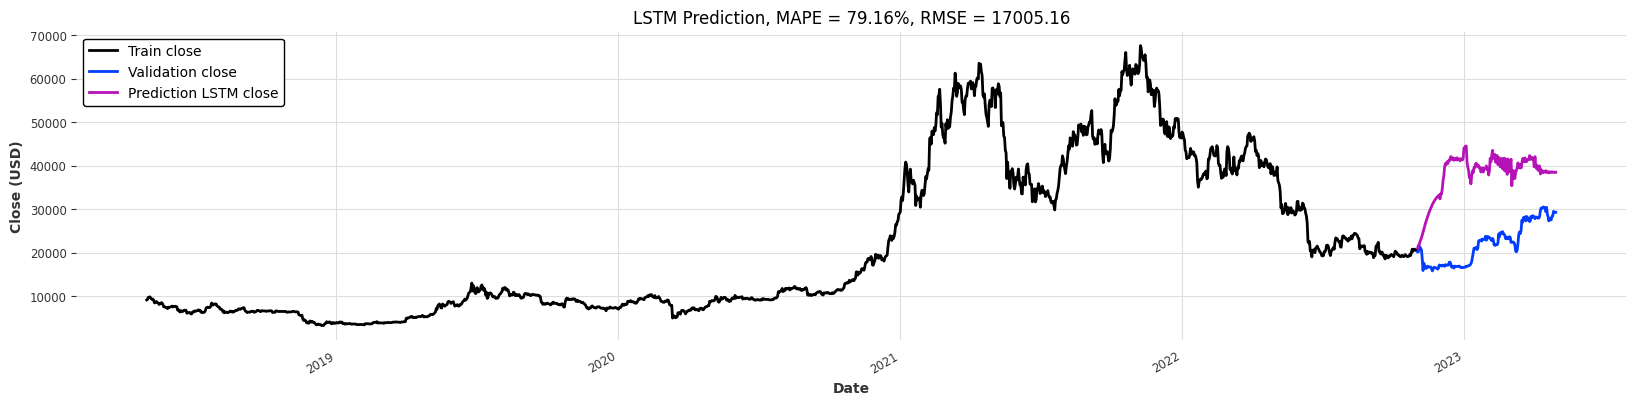

In [40]:
# plot the prediction 
train_close.plot(label='Train close')
val_close.plot(label='Validation close')
future_lstm['Close'].plot(label='Prediction LSTM close')

print("MAPE = {:.2f}%".format(mape(val_close, future_lstm['Close'])))

# Add the legend with a box
legend = plt.legend(loc="upper left", frameon=True)
plt.title(f"LSTM Prediction, MAPE = {mape(val_close, future_lstm['Close']):.2f}%, RMSE = {rmse(val_close, future_lstm['Close']):.2f}")
plt.ylabel('Close (USD)')
# Customize the appearance of the legend box
legend.get_frame().set_facecolor("white")  # Set the background color
legend.get_frame().set_edgecolor("black")  # Set the edge color
legend.get_frame().set_alpha(1)  # Set the transparency (0: fully transparent, 1: fully opaque)
plt.show()

09:34:30 - cmdstanpy - INFO - Chain [1] start processing
09:34:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 84.19%


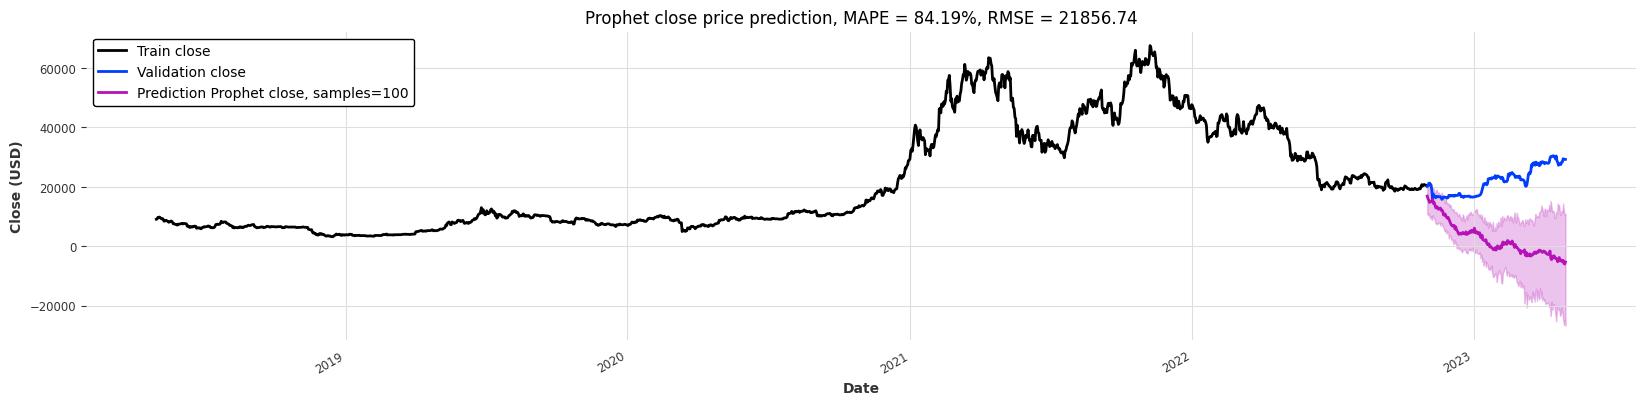

In [10]:
# make prophet model
model_prophet = Prophet()
model_prophet.fit(train_close)

# make the prediction using prophet
future_prophet = model_prophet.predict(n=len(val_close), num_samples=100)
# future_prophet = scalar_close.inverse_transform(future_prophet)

# plot the prediction
train_close.plot(label='Train close')
val_close.plot(label='Validation close')
future_prophet.plot(label='Prediction Prophet close, samples=100')

print("MAPE = {:.2f}%".format(mape(val_close, future_prophet)))

# Add the legend with a box
legend = plt.legend(loc="upper left", frameon=True)
plt.title(f"Prophet close price prediction, MAPE = {mape(val_close, future_prophet):.2f}%, RMSE = {rmse(val_close, future_prophet['Close']):.2f}")
# Customize the appearance of the legend box
plt.ylabel("Close (USD)")
legend.get_frame().set_facecolor("white")  # Set the background color
legend.get_frame().set_edgecolor("black")  # Set the edge color
legend.get_frame().set_alpha(1)  # Set the transparency (0: fully transparent, 1: fully opaque)
plt.show()

In [42]:
# make ARIMA model
model_arima = ARIMA()
param_grid = {'p': [5, 4, 3, 2, 1], 'd': [2, 1, 0], 'q': [4, 3, 2, 1]}
best_params = model_arima.gridsearch(param_grid, series=train_close, val_series=val_close)

# initialize ARIMA model with best parameters
print(best_params[1])
model_arima = ARIMA(p=best_params[1]['p'], d=best_params[1]['d'], q=best_params[1]['q'])
model_arima.fit(train_close)

/home/malthe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/malthe/.local/lib/python3.10/site-p

{'p': 5, 'd': 2, 'q': 3}


/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE = 17.17%


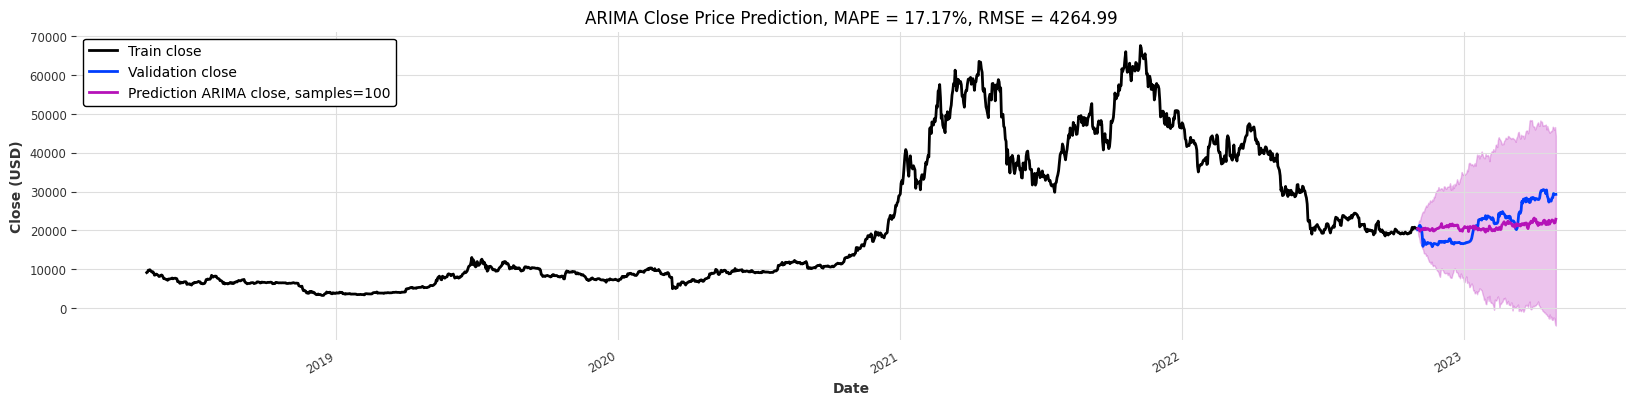

In [43]:
# make the prediction using ARIMA
future_arima = model_arima.predict(n=len(val_close), num_samples=100)

# plot the prediction
train_close.plot(label='Train close')
val_close.plot(label='Validation close')
future_arima.plot(label='Prediction ARIMA close, samples=100')

print("MAPE = {:.2f}%".format(mape(val_close, future_arima)))

# Add the legend with a box
legend = plt.legend(loc="upper left", frameon=True)
plt.title(f"ARIMA Close Price Prediction, MAPE = {mape(val_close, future_arima):.2f}%, RMSE = {rmse(val_close, future_arima['Close']):.2f}")
# Customize the appearance of the legend box
plt.ylabel("Close (USD)")
legend.get_frame().set_facecolor("white")  # Set the background color
legend.get_frame().set_edgecolor("black")  # Set the edge color
legend.get_frame().set_alpha(1)  # Set the transparency (0: fully transparent, 1: fully opaque)
plt.show()

In [44]:
# make VARIMA model
# model_varima = VARIMA()

# param_grid = {'p': [5, 1], 'd': [1, 0], 'q': [1, 0]}
# best_params = model_varima.gridsearch(param_grid, series=train_multi_sc, val_series=val_multi_sc)

# initialize VARIMA model with best parameters
# print(best_params[1])
# model_varima = VARIMA(p=best_params[1]['p'], d=best_params[1]['d'], q=best_params[1]['q'])
model_varima = VARIMA(5, 1, 1)
model_varima.fit(train_multi_sc)

/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


MAPE = 19.93%


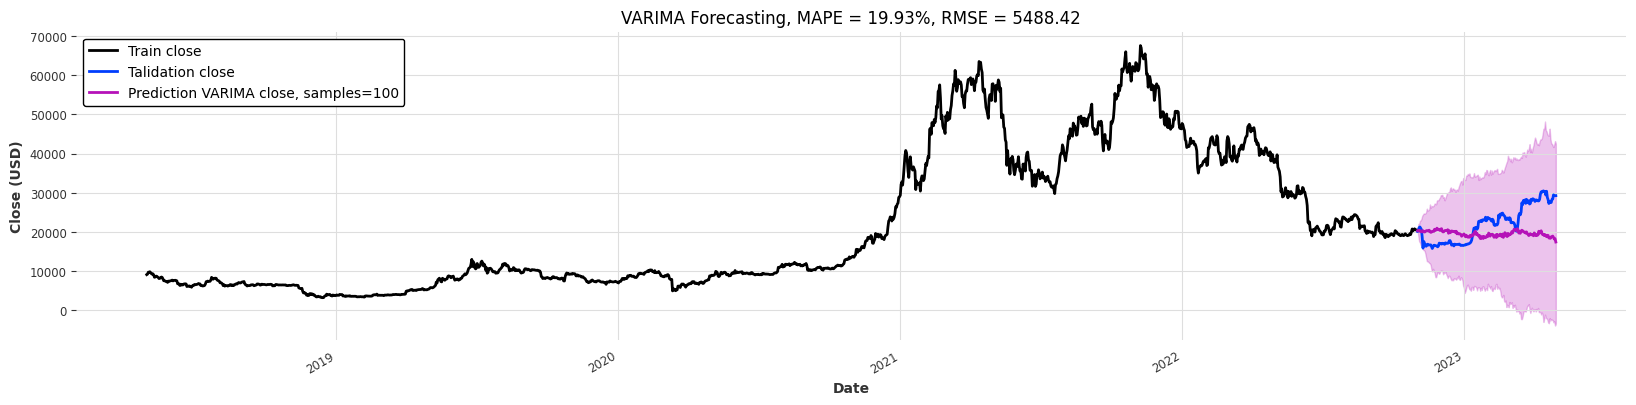

In [45]:
# make the prediction using VARIMA
future_varima = model_varima.predict(n=len(val_close), num_samples=100)
future_varima = scalar_multi.inverse_transform(future_varima)

# plot the prediction
train_close.plot(label='Train close')
val_close.plot(label='Talidation close')
future_varima['Close'].plot(label='Prediction VARIMA close, samples=100')

print("MAPE = {:.2f}%".format(mape(val_close, future_varima['Close'])))

# Add the legend with a box
legend = plt.legend(loc="upper left", frameon=True)
plt.title(f"VARIMA Forecasting, MAPE = {mape(val_close, future_varima['Close']):.2f}%, RMSE = {rmse(val_close, future_varima['Close']):.2f}")
# Customize the appearance of the legend box
plt.ylabel("Close (USD)")
legend.get_frame().set_facecolor("white")  # Set the background color
legend.get_frame().set_edgecolor("black")  # Set the edge color
legend.get_frame().set_alpha(1)  # Set the transparency (0: fully transparent, 1: fully opaque)
plt.show()

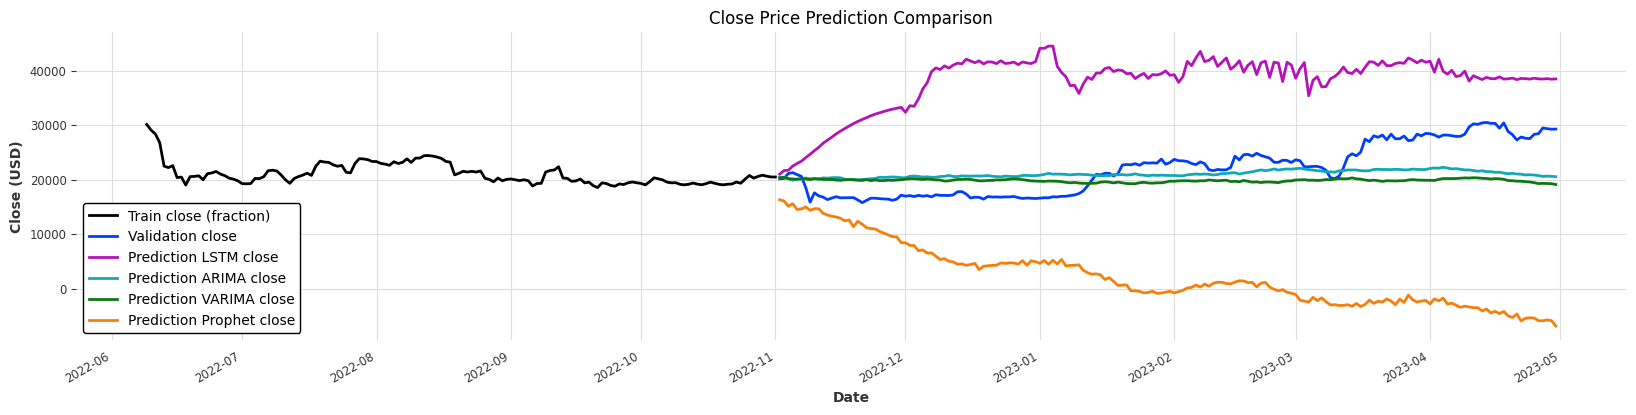

In [47]:
train_close[1500:].plot(label='Train close (fraction)')
val_close.plot(label='Validation close')

point_prophet = future_prophet.mean()
point_arima = future_arima.mean()
point_varima = future_varima['Close'].mean()
point_lstm = future_lstm.mean()

plt.rcParams['figure.figsize'] = [20, 4]


future_lstm['Close'].plot(label='Prediction LSTM close')
point_arima.plot(label='Prediction ARIMA close')
point_varima.plot(label='Prediction VARIMA close')
point_prophet.plot(label='Prediction Prophet close')

# Add the legend with a box
legend = plt.legend(loc="lower left", frameon=True)
plt.title("Close Price Prediction Comparison")
# Customize the appearance of the legend box
plt.ylabel("Close (USD)")
legend.get_frame().set_facecolor("white")  # Set the background color
legend.get_frame().set_edgecolor("black")  # Set the edge color
legend.get_frame().set_alpha(1)  # Set the transparency (0: fully transparent, 1: fully opaque)
plt.show()